In [1]:
import torch
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor


train_data = MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True
)

test_data = MNIST(
    root = 'data',
    train = False,
    transform = ToTensor(),
    download = True
)

from torch.utils.data import DataLoader

loaders = {
    
    'train': DataLoader(train_data,
                        batch_size=100,
                        shuffle=True,
                        num_workers=1),
    'test': DataLoader(test_data,
                        batch_size=100,
                        shuffle=True,
                        num_workers=1),
    
}

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class CNN(nn.Module): # CNN to Convolutional Neural Network Chodzi o to, że robimy 2 typy warstw conv i fc(liniowa)
    
    def __init__(self):
        super(CNN, self).__init__() #wywołanie konstruktora dziedziczącego 
        
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)  #2D warstwa z 1 -> 10 "kółeczek"
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop= nn.Dropout2d() #warstwa regulująca co wywala niektóre neurony, żeby niepotrzebnie je trenować
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10) #na końcu 10 bo tyle jest cyfr
        
    def forward(self, x): #instrukcja przejścia dalej
        x = F.relu(F.max_pool2d(self.conv1(x),2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
        x = x.view(-1, 320) #20x4x4
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        
        return F.softmax(x, dim=1)

In [6]:
import torch

device = torch.device('cpu')

model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target) #kalkulacja strat
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(loaders["train"].dataset)} ({100. * batch_idx / len(loaders["train"]):.0f}%)]\t {loss.item():.6f}')
    
def test():
    model.eval()
    
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(loaders['test'].dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy {correct}/{len(loaders["test"].dataset)} ({100. * correct / len(loaders["test"].dataset):.0f}%\n)')
    print(f'{len(loaders["test"].dataset)}')

for epoch in range(1,10):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	 2.305127
Train Epoch: 1 [10000/60000 (17%)]	 1.856265
Train Epoch: 1 [20000/60000 (33%)]	 1.738107
Train Epoch: 1 [30000/60000 (50%)]	 1.638742
Train Epoch: 1 [40000/60000 (67%)]	 1.677487
Train Epoch: 1 [50000/60000 (83%)]	 1.641431

Test set: Average loss: 0.0153, Accuracy 9358/10000 (94%
)
10000
Train Epoch: 2 [0/60000 (0%)]	 1.617285
Train Epoch: 2 [10000/60000 (17%)]	 1.570582
Train Epoch: 2 [20000/60000 (33%)]	 1.556255
Train Epoch: 2 [30000/60000 (50%)]	 1.557570
Train Epoch: 2 [40000/60000 (67%)]	 1.596002
Train Epoch: 2 [50000/60000 (83%)]	 1.593761

Test set: Average loss: 0.0151, Accuracy 9507/10000 (95%
)
10000
Train Epoch: 3 [0/60000 (0%)]	 1.563312
Train Epoch: 3 [10000/60000 (17%)]	 1.540113
Train Epoch: 3 [20000/60000 (33%)]	 1.585907
Train Epoch: 3 [30000/60000 (50%)]	 1.522997
Train Epoch: 3 [40000/60000 (67%)]	 1.575076
Train Epoch: 3 [50000/60000 (83%)]	 1.582810

Test set: Average loss: 0.0150, Accuracy 9612/10000 (96%
)
10000
Train E

Prediction: 2


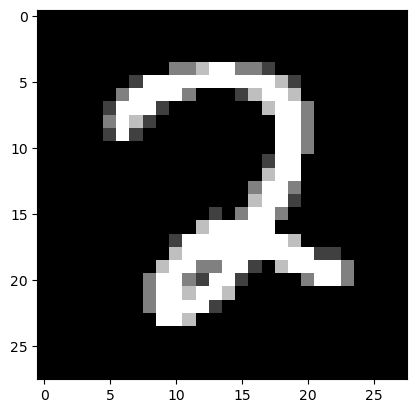

In [4]:
import matplotlib.pyplot as plt


model.eval()
data, target =  test_data[3257]#'C:\\Users\\Marcin\\Downloads\\3.png'
data = data.unsqueeze(0).to(device)
output = model(data)
prediction = output.argmax(dim=1, keepdim=True).item()

print(f'Prediction: {prediction}')

image = data.squeeze(0).squeeze(0).cpu().numpy()
plt.imshow(image, cmap='gray')
plt.show()

Prediction: 7


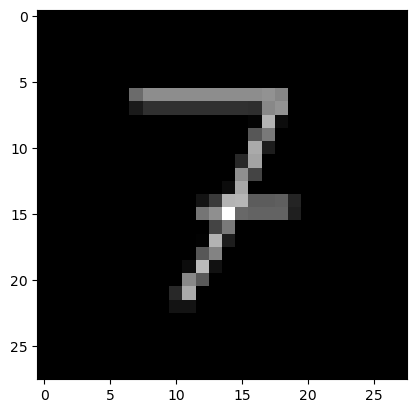

In [10]:
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt

#Przygotowanie pliku
file = 'C:\\Users\\Marcin\\Downloads\\7.png'
img = Image.open(file)
img = img.resize((28, 28))

#Zmiana koloru
img = img.convert('L')
new_img = Image.new('L', (28, 28), 255)
inverted_img = ImageOps.invert(img)
new_img.paste(inverted_img, (0, 0))

image_arr = np.array(new_img)
image_tens = torch.tensor(image_arr)
image_tens = image_tens.view(1, 28, 28).to(dtype=torch.float32)

import matplotlib.pyplot as plt


model.eval()
data, target =  [image_tens,3]
data = data.unsqueeze(0).to(device)
output = model(data)
prediction = output.argmax(dim=1, keepdim=True).item()

print(f'Prediction: {prediction}')

image = data.squeeze(0).squeeze(0).cpu().numpy()
plt.imshow(image, cmap='gray')
plt.show()
